# AAE with no pretraining: Performance evaluation

Jacqueline R. M. A. Maasch | May 2022

## Preamble

In [182]:
# Importations.
import moses
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from moses.metrics import weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses import get_dataset
from collections import OrderedDict
from tdc.chem_utils import MolFilter
import warnings
from tdc import Oracle
from rdkit import Chem                                                                                                                                                                   
from rdkit import RDLogger 
from random import sample
import tdc
from tdc import Evaluator
from tdc.single_pred import HTS
from importlib.metadata import version

In [183]:
# View versioning.
print("\npython version:", sys.version)
print("\n--- LIBRARY VERSIONS ---")
print("tdc:         ", version("PyTDC"))
print("numpy:       ", version("numpy"))
print("pandas:      ", version("pandas"))
print("moses:       ", version("molsets"))
print("rdkit:       ", version("rdkit-pypi"))
print("scipy:       ", version("scipy"))
print("seaborn:     ", version("seaborn"))
print("matplotlib:  ", version("matplotlib"))


python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]

--- LIBRARY VERSIONS ---
tdc:          0.3.6
numpy:        1.22.3
pandas:       1.2.4
moses:        0.3.1
rdkit:        2021.9.5.1
scipy:        1.7.2
seaborn:      0.11.1
matplotlib:   3.3.4


In [184]:
%%capture
# Installs.
#!python3.8 -m pip install fcd_torch
#!python3.8 -m pip install rxn4chemistry

## Define functions

In [185]:
def compute_tdc_metrics(generated, training):
    
    metrics_dict = dict()
    
    kl = Evaluator(name = "KL_Divergence")
    metrics_dict["KL divergence"] = kl(generated, training)

    uniqueness = Evaluator(name = "Uniqueness")
    metrics_dict["Uniqueness"] = uniqueness(generated)

    validity = Evaluator(name = "Validity")
    metrics_dict["Validity"] = validity(generated)

    novelty = Evaluator(name = "Novelty")
    metrics_dict["Novelty"] = novelty(generated, training)

    #fcd = Evaluator(name = "FCD_Distance")
    #metrics_dict["FCD distance"] = fcd(generated, training)

    diversity = Evaluator(name = "Diversity")
    metrics_dict["Diversity"] = diversity(generated)

    return metrics_dict


def remove_ungrammatical(generated):
    # Disable warnings.
    RDLogger.DisableLog("rdApp.*")  
    
    # Filter molecules.
    keep = []
    invalid_string = 0
    invalid_chemistry = 0
    for molecule in generated:
        m = Chem.MolFromSmiles(molecule, sanitize = False)
        if m is None:
            invalid_string += 1
        else:
            try:
                Chem.SanitizeMol(m)
                keep.append(molecule)
            except:
                invalid_chemistry += 1
                
    print("Total strings with invalid SMILES syntax:", invalid_string)
    print("Total strings with invalid chemistry:", invalid_chemistry)
    print("Total valid SMILES strings:", len(keep))
    print("Percent valid SMILES strings:", (len(keep) / len(generated)))
    
    return keep


def plot_distribution_basic(df, 
                            log_x = None, 
                            log_y = None, 
                            save_path = "./plt.pdf", 
                            save = False):
    
    sns.displot(data = df, 
                x = "Value", 
                hue = "Distribution", 
                col = "Metric",
                kind = "kde", 
                log_scale = (log_x, log_y),
                common_norm = True,
                fill = True,
                height = 5)
    if save:
        plt.savefig(save_path)
    else:
        plt.show()
    
    
def plot_distribution(df, 
                      log_x = None, 
                      log_y = None, 
                      save_path = "./plt.pdf", 
                      save = False):
    
    g = sns.FacetGrid(df.reset_index(), 
                      col = "Metric",
                      hue = "Distribution", 
                      sharex = False, 
                      sharey = False)
    g.map_dataframe(sns.kdeplot, 
                    "Value",
                    fill = True, 
                    log_scale = (log_x, log_y),
                    common_norm = True).add_legend()
    if save:
        plt.savefig(save_path)
    else:
        plt.show()

## Read data

### Generated molecules

In [186]:
# Read in generated molecules.
df_active = pd.read_csv("../aae/generated_molecules_100k/gen_active_finetune_all.csv")
df_inactive = pd.read_csv("../aae/generated_molecules_100k/gen_inactive_finetune_all.csv")

print(df_active.info())
display(df_active.head())

print(df_inactive.info())
display(df_inactive.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,O=CCNc1ccccc1CN1CCOCC1<pad><pad><pad><pad><pad...
1,Nc1cc(Br)c(O)c2ccc(O)c12<pad><pad><pad><pad><p...
2,Cc1[nH]ncc1NS(=O)(=O)c1ccc(Br)cc1<pad><pad><pa...
3,CSc1cc(OC)c2ncnc(N3CCCCCC3)c2c1<pad><pad><pad>...
4,COc1ccc2nc(S(N)=O)sc2c1<pad><pad><pad><pad><pa...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,O=S11CN(=O)OC(Cl)=C1Cl<pad><pad><pad><pad><pad...
1,COCCN(CCCC(N)=O)CS(N)(=O)=O<pad><pad><pad><pad...
2,Cc1[nH]c(C)c2ncnc12=N<pad><pad><pad><pad><pad>...
3,Cc1cc(-c2ncc(N)nc2)nn1C<pad><pad><pad><pad><pa...
4,COc1ccc(C(N)C(=O)O)cc1<pad><pad><pad><pad><pad...


### Training data from TDC

In [187]:
df_active_train = pd.read_csv("../sars_data/actives_train.csv")
df_inactive_train = pd.read_csv("../sars_data/inactives_train.csv")

print(df_active_train.info())
display(df_active_train.head())
print(df_inactive_train.info())
display(df_inactive_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  132 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
None


,SMILES
0,NC(=O)c1ccc(NC(=O)[C@@H]2CCCO2)cc1
1,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl
2,COC(=O)Nc1sc(C)nc1-c1ccccc1
3,OC1CCN(Cc2ccsc2)CC1
4,CC(C(O)c1ccc(O)cc1)N1CCC(Cc2ccccc2)CC1.CC(C(O)...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1758 non-null   object
dtypes: object(1)
memory usage: 13.9+ KB
None


,SMILES
0,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1
1,COc1cc(Br)c(C[N+]2(CCOCCC3CCC4CC3C4(C)C)CCOCC2...
2,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1
3,COCC1=C(C(=O)OC(C)OC(=O)OC(C)C)N2C(=O)[C@@H](N...
4,c1nc(N2CCC2)c2[nH]cnc2n1


### Validation data

In [188]:
df_active_val = pd.read_csv("../sars_data/actives_val.csv")
df_inactive_val = pd.read_csv("../sars_data/inactives_val.csv")

print(df_active_val.info())
display(df_active_val.head())
print(df_inactive_val.info())
display(df_inactive_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  34 non-null     object
dtypes: object(1)
memory usage: 400.0+ bytes
None


,SMILES
0,O=C(CCl)N1CCN(Cc2cccc3ccccc23)CC1
1,O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1
2,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...
3,C/C=C/c1ccc(OC)cc1
4,Clc1cccc(CN2CCOCC2)c1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  440 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB
None


,SMILES
0,CCC1(C)CC(=O)NC1=O
1,CC(=O)N[C@@H](CCC(N)=O)C(=O)O
2,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O
3,CC(C)n1cnc(S(N)(=O)=O)c1
4,Cc1ccc(=O)n(-c2ccccc2)c1


## Process data

In [189]:
# Remove padding.
remove_pad = lambda x: x.replace("<pad>", "")
df_active.SMILES = df_active.SMILES.map(remove_pad)
df_inactive.SMILES = df_inactive.SMILES.map(remove_pad)

In [190]:
# Listify.
actives_gen = list(df_active.SMILES)
inactives_gen = list(df_inactive.SMILES)

actives_train = list(df_active_train.SMILES)
inactives_train = list(df_inactive_train.SMILES)

actives_val = list(df_active_val.SMILES)
inactives_val = list(df_inactive_val.SMILES)

In [191]:
# Filter out molecules that do not pass RDKit checks.
# Some metrics will require this step.
print("--- de novo actives ---")
actives_gen_grammatical = remove_ungrammatical(actives_gen)
print("\n--- de novo inactives ---")
inactives_gen_grammatical = remove_ungrammatical(inactives_gen)
print("\n--- training actives ---")
actives_train_grammatical = remove_ungrammatical(actives_train)
print("\n--- training inactives ---")
inactives_train_grammatical = remove_ungrammatical(inactives_train)
print("\n--- validation actives ---")
actives_val_grammatical = remove_ungrammatical(actives_val)
print("\n--- validation inactives ---")
inactives_val_grammatical = remove_ungrammatical(inactives_val)

--- de novo actives ---
Total strings with invalid SMILES syntax: 25534
Total strings with invalid chemistry: 7940
Total valid SMILES strings: 66526
Percent valid SMILES strings: 0.66526

--- de novo inactives ---
Total strings with invalid SMILES syntax: 45159
Total strings with invalid chemistry: 8809
Total valid SMILES strings: 46032
Percent valid SMILES strings: 0.46032

--- training actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 132
Percent valid SMILES strings: 1.0

--- training inactives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 1758
Percent valid SMILES strings: 1.0

--- validation actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 34
Percent valid SMILES strings: 1.0

--- validation inactives ---
Total strings with invalid SMILES syntax: 0
Total strings wit

## Global-level metrics

### MOSES metrics

In [192]:
moses.get_all_metrics?

Signature:
moses.get_all_metrics(
    gen,
    k=None,
    n_jobs=1,
    device='cpu',
    batch_size=512,
    pool=None,
    test=None,
    test_scaffolds=None,
    ptest=None,
    ptest_scaffolds=None,
    train=None,
)
Docstring:
Computes all available metrics between test (scaffold test)
and generated sets of SMILES.
Parameters:
    gen: list of generated SMILES
    k: int or list with values for unique@k. Will calculate number of
        unique molecules in the first k molecules. Default [1000, 10000]
    n_jobs: number of workers for parallel processing
    device: 'cpu' or 'cuda:n', where n is GPU device number
    batch_size: batch size for FCD metric
    pool: optional multiprocessing pool to use for parallelization

    test (None or list): test SMILES. If None, will load
        a default test set
    test_scaffolds (None or list): scaffold test SMILES. If None, will
        load a default scaffold test set
    ptest (None or dict): precalculated statistics of the test set. 

In [193]:
# Compute MOSES metrics for de novo actives.
start_time = time.time()
metrics_active = moses.get_all_metrics(gen = actives_gen, train = actives_train, test = actives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_active)

Complete in 3175.9092411994934 seconds.


{'valid': 0.66524,
 'unique@1000': 0.903,
 'unique@10000': 0.8081,
 'FCD/Test': 28.42573152718714,
 'SNN/Test': 0.26710987437828254,
 'Frag/Test': 0.7772472486220111,
 'Scaf/Test': 0.1888512395958325,
 'FCD/TestSF': 8.88109249321208,
 'SNN/TestSF': 0.5054625655573656,
 'Frag/TestSF': 0.8859348858473205,
 'Scaf/TestSF': 0.20758334624403962,
 'IntDiv': 0.865058128802112,
 'IntDiv2': 0.852915418910209,
 'Filters': 0.7939390295231796,
 'logP': 0.512205079661653,
 'SA': 0.5368695873340511,
 'QED': 0.14395093063519854,
 'weight': 93.36377547333655,
 'Novelty': 0.9984325677587896}

In [194]:
# Compute MOSES metrics for de novo inactives.
start_time = time.time()
metrics_inactive = moses.get_all_metrics(gen = inactives_gen, train = inactives_train, test = inactives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_inactive)

Complete in 2121.677400112152 seconds.


{'valid': 0.46031,
 'unique@1000': 0.983,
 'unique@10000': 0.9338,
 'FCD/Test': 7.694011338924206,
 'SNN/Test': 0.32094426309559865,
 'Frag/Test': 0.9492083760259348,
 'Scaf/Test': 0.23407528778805475,
 'FCD/TestSF': 8.92542084904747,
 'SNN/TestSF': 0.4493443960394865,
 'Frag/TestSF': 0.9155687257180947,
 'Scaf/TestSF': 0.1564377066299123,
 'IntDiv': 0.8847789732797021,
 'IntDiv2': 0.8738292927161534,
 'Filters': 0.9337620299363473,
 'logP': 0.6186695765847524,
 'SA': 0.5018154135977194,
 'QED': 0.08919395070674181,
 'weight': 95.43561808094749,
 'Novelty': 0.9948627959614456}

### TDC metrics

In [195]:
# NOTE: must subsample generative inactives to < 10k to get TDC functions to work.
# This is due to a glitch in TDC.
actives_gen_grammatical_10k = sample(actives_gen_grammatical, 10000)
inactives_gen_grammatical_10k = sample(inactives_gen_grammatical, 10000)

In [196]:
%%capture
# Throws error.
'''
ompute all metrics for active de novos vs their training data.
compute_tdc_metrics(actives_gen_grammatical, actives_train_grammatical)
'''

In [197]:
# KL divergence of active generated data and active training data.
kl = Evaluator(name = "KL_Divergence")
kl(actives_gen_grammatical_10k, actives_train_grammatical)

RDKit ERROR: [02:45:36] Explicit valence for atom # 16 O, 3, is greater than permitted
[02:45:36] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [02:46:02] Explicit valence for atom # 16 O, 3, is greater than permitted
[02:46:02] Explicit valence for atom # 16 O, 3, is greater than permitted


0.4838310382662775

In [198]:
%%capture
# Throws error.
'''
# Compute all metrics for inactive de novos vs their training data.
compute_tdc_metrics(inactives_gen_grammatical_10k, inactives_train_grammatical)
'''

In [199]:
# KL divergence of inactive generated data and inactive training data.
kl(inactives_gen_grammatical_10k, inactives_train_grammatical)

RDKit ERROR: [02:46:36] Explicit valence for atom # 5 N, 4, is greater than permitted
[02:46:36] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [02:46:58] Explicit valence for atom # 5 N, 4, is greater than permitted
[02:46:58] Explicit valence for atom # 5 N, 4, is greater than permitted


0.6145992187147822

In [200]:
# KL divergence of active training data and inactive training data.
kl(actives_train_grammatical, inactives_train_grammatical)

0.854377160131264

In [201]:
# KL divergence of active de novos and inactive training data.
kl(actives_gen_grammatical_10k, inactives_train_grammatical)

RDKit ERROR: [02:47:29] Explicit valence for atom # 16 O, 3, is greater than permitted
[02:47:29] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [02:48:00] Explicit valence for atom # 16 O, 3, is greater than permitted
[02:48:00] Explicit valence for atom # 16 O, 3, is greater than permitted


0.5154881953557446

In [202]:
# KL divergence of inactive de novos and active training data.
kl(inactives_gen_grammatical_10k, actives_train_grammatical)

RDKit ERROR: [02:48:33] Explicit valence for atom # 5 N, 4, is greater than permitted
[02:48:33] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [02:48:49] Explicit valence for atom # 5 N, 4, is greater than permitted
[02:48:49] Explicit valence for atom # 5 N, 4, is greater than permitted


0.5603305042752899

In [203]:
# KL divergence of active de novos and inactive de novos.
kl(actives_gen_grammatical_10k, inactives_gen_grammatical_10k)

RDKit ERROR: [02:49:15] Explicit valence for atom # 16 O, 3, is greater than permitted
[02:49:15] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [02:49:46] Explicit valence for atom # 5 N, 4, is greater than permitted
[02:49:46] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [02:50:03] Explicit valence for atom # 5 N, 4, is greater than permitted
[02:50:03] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [02:50:23] Explicit valence for atom # 16 O, 3, is greater than permitted
[02:50:23] Explicit valence for atom # 16 O, 3, is greater than permitted


0.8816961809049808

## Molecule-level metrics

### Synthetic accessibility

>Description: Synthetic Accessibility Score stands for how hard or how easy it is to synthesize a given molecule, based on a combination of the molecule’s fragments contributions. The oracle is caluated via RDKit, using a set of chemical rules defined by Ertl et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility]

In [204]:
# Synthetic accessibility.
sa = Oracle(name = "SA")

'''
sa_actives_gen = sa(actives_gen_grammatical)
sa_inactives_gen = sa(inactives_gen_grammatical)
sa_actives_train = sa(actives_train_grammatical)
sa_inactives_train = sa(inactives_train_grammatical)
'''

invalid = 0
sa_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_gen))

invalid = 0
sa_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_gen))

invalid = 0
sa_actives_train = []
for molecule in actives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_train))

invalid = 0
sa_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_train))

print()
sa_dict = {"Generated actives": sa_actives_gen,
           "Generated inactives": sa_inactives_gen,
           "Training actives": sa_actives_train,
           "Training inactives": sa_inactives_train}

for key,value in sa_dict.items():
    print(key, ":")
    print(value[:20], "\n")


Total invalid: 0
Total valid: 66526

Total invalid: 0
Total valid: 46032

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[2.1649588895328638, 2.2525814754575784, 2.381473885249319, 3.1464735974398987, 3.8382799144196316, 2.415053663183752, 2.0750451690702736, 5.612478130874769, 2.6157499345463133, 1.9738588649059423, 1.7083975080571978, 2.175351507627081, 2.0625621715540454, 2.374912650694336, 3.615630229682991, 2.4475395095622527, 2.5177193290933033, 2.036413977480125, 1.9963583446246211, 2.2784450433790173] 

Generated inactives :
[2.685726497326355, 2.6660770353962793, 2.1284127110380755, 1.9208201597197245, 1.648021542033094, 2.7206325270879397, 2.704695282570924, 1.856788760997837, 1.6921528721807704, 2.0473611428189606, 3.476265995796977, 1.2760584468553642, 2.0376276242984215, 1.8252348510713272, 2.3395323756212445, 2.8092129564191044, 2.532521934867656, 1.6806199649444444, 1.6382957404463827, 2.350099851335493] 

Training actives :
[

### QED

> Description: QED stands for Quantitative Estimate of Drug-likeness. The oracle is caluated via RDKit, using a set of chemical rules about drug-likeliness defined by Bickerton et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [205]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
inactives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in inactives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            inactives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo inactives with invalid valence:", invalid_valence)
print("Total de novo inactives with valid valence:", len(inactives_gen_grammatical_keep))

RDKit ERROR: [02:57:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[02:57:47] Explicit valence for atom # 5 N, 4, is greater than permitted


Total de novo inactives with invalid valence: 1
Total de novo inactives with valid valence: 46031


In [206]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
actives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in actives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            actives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo actives with invalid valence:", invalid_valence)
print("Total de novo actives with valid valence:", len(actives_gen_grammatical_keep))

RDKit ERROR: [02:57:59] Explicit valence for atom # 12 N, 4, is greater than permitted
[02:57:59] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [02:58:05] Explicit valence for atom # 9 O, 3, is greater than permitted
[02:58:05] Explicit valence for atom # 9 O, 3, is greater than permitted


Total de novo actives with invalid valence: 2
Total de novo actives with valid valence: 66524


In [207]:
# Quantitative Estimate of Drug-likeness.
qed = Oracle(name = "QED")
qed_actives_gen = qed(actives_gen_grammatical_keep) # Use only instances with proper valence.
qed_inactives_gen = qed(inactives_gen_grammatical_keep) # Use only instances with proper valence.
qed_actives_train = qed(actives_train_grammatical)
qed_inactives_train = qed(inactives_train_grammatical)

qed_dict = {"Generated actives": qed_actives_gen,
            "Generated inactives": qed_inactives_gen,
            "Training actives": qed_actives_train,
            "Training inactives": qed_inactives_train}

for key,value in qed_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[0.7754562442257183, 0.9120720287267751, 0.8075953910764619, 0.8418383182789958, 0.6413549818706119, 0.7791884056079403, 0.7700738055285151, 0.5531094596134559, 0.4688795543694978, 0.864264551426556, 0.8210848938505647, 0.9218352662522913, 0.7942512711461569, 0.6244415007466811, 0.8574877619278379, 0.8379684576488766, 0.8725513416486739, 0.7345056113540349, 0.5913631026036211, 0.7186659220971477] 

Generated inactives :
[0.515644052106168, 0.7188603016780706, 0.7222849484937856, 0.8916849975517066, 0.7791053618775996, 0.6119063719787395, 0.5065276303950935, 0.7605635623635456, 0.7418980134197941, 0.7897529413882469, 0.6106087402996582, 0.6655165943403577, 0.5467956689861363, 0.6625105224317028, 0.7783359648659989, 0.6055356531723399, 0.8881477368439521, 0.7860222207783902, 0.6371711581617848, 0.39602445613699344] 

Training actives :
[0.814913995911437, 0.7209997551181787, 0.8867424621741485, 0.7798427952514674, 0.08557107474966161, 0.7958887434961184, 0.61136693250

### Octanol-water Partition Coefficient (LogP)

>Description: The penalized logP score measures the solubility and synthetic accessibility of a compound. The oracle is caluated via RDKit. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [208]:
# LogP.
logp = Oracle(name = "LogP")

'''
logp_actives_gen = logp(actives_gen_grammatical)
logp_inactives_gen = logp(inactives_gen_grammatical)
logp_actives_train = logp(actives_train_grammatical)
logp_inactives_train = logp(inactives_train_grammatical)
'''

invalid = 0
logp_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_gen))

invalid = 0
logp_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_gen))

invalid = 0
logp_actives_train = []
for molecule in actives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_train))

invalid = 0
logp_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_train))

print()
logp_dict = {"Generated actives": logp_actives_gen,
             "Generated inactives": logp_inactives_gen,
             "Training actives": logp_actives_train,
             "Training inactives": logp_inactives_train}

for key,value in logp_dict.items():
    print(key, ":")
    print(value[:20], "\n")


Total invalid: 0
Total valid: 66526

Total invalid: 0
Total valid: 46032

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[0.3091991439893007, 1.007115769827652, -1.6263657000201517, -0.759173419020815, -0.3281425804304914, 0.9546851440825932, 2.500058994750614, -19.17310283847809, 0.1806701313250959, 1.6939942251781672, 1.409962616016342, 1.2861861889391573, 0.9587764044508459, 0.35361801459446107, -1.2655622419417787, 0.6365550745387025, 0.36355853376553693, 0.646919389892852, 1.0571667701480905, 0.31318203473130346] 

Generated inactives :
[-2.1863577408347403, -0.5443074216367052, 0.10902737728845757, 2.05281760519163, 0.6691226123976133, -0.1374951411722079, -0.4415931203383471, 0.8181494813810902, 1.6511589643912814, 0.8729924398089479, -2.6225646706657013, 3.088097687660602, -0.14745351866202627, 2.170631556924143, 1.112792480559483, -1.0024664209338852, 0.5963006112388831, 1.6967873132270346, 2.6871710958417356, -0.6981678121410457] 


### Dictionary to dataframe

In [209]:
# SA.
df_sa = pd.DataFrame()
for key,value in sa_dict.items():
    df_sa = pd.concat([df_sa, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_sa["Metric"] = "SA"
display(df_sa)

,Distribution,Value,Metric
0,Generated actives,2.164959,SA
1,Generated actives,2.252581,SA
2,Generated actives,2.381474,SA
3,Generated actives,3.146474,SA
4,Generated actives,3.838280,SA
...,...,...,...
1753,Training inactives,1.919343,SA
1754,Training inactives,2.494935,SA
1755,Training inactives,4.908138,SA
1756,Training inactives,2.417861,SA


In [210]:
# QED.
df_qed = pd.DataFrame()
for key,value in qed_dict.items():
    df_qed = pd.concat([df_qed, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_qed["Metric"] = "QED"
display(df_qed)

,Distribution,Value,Metric
0,Generated actives,0.775456,QED
1,Generated actives,0.912072,QED
2,Generated actives,0.807595,QED
3,Generated actives,0.841838,QED
4,Generated actives,0.641355,QED
...,...,...,...
1753,Training inactives,0.736693,QED
1754,Training inactives,0.877740,QED
1755,Training inactives,0.675608,QED
1756,Training inactives,0.834182,QED


In [211]:
# LogP.
df_logp = pd.DataFrame()
for key,value in logp_dict.items():
    df_logp = pd.concat([df_logp, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_logp["Metric"] = "LogP"
display(df_logp)

,Distribution,Value,Metric
0,Generated actives,0.309199,LogP
1,Generated actives,1.007116,LogP
2,Generated actives,-1.626366,LogP
3,Generated actives,-0.759173,LogP
4,Generated actives,-0.328143,LogP
...,...,...,...
1753,Training inactives,1.354121,LogP
1754,Training inactives,1.682860,LogP
1755,Training inactives,-1.982381,LogP
1756,Training inactives,0.699492,LogP


In [212]:
# Aggregate all results.
df_metrics = pd.concat([df_sa, df_qed, df_logp]).reset_index(drop = True)
print(df_metrics.info())
display(df_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343341 entries, 0 to 343340
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Distribution  343341 non-null  object 
 1   Value         343341 non-null  float64
 2   Metric        343341 non-null  object 
dtypes: float64(1), object(2)
memory usage: 7.9+ MB
None


,Distribution,Value,Metric
0,Generated actives,2.164959,SA
1,Generated actives,2.252581,SA
2,Generated actives,2.381474,SA
3,Generated actives,3.146474,SA
4,Generated actives,3.838280,SA
...,...,...,...
343336,Training inactives,1.354121,LogP
343337,Training inactives,1.682860,LogP
343338,Training inactives,-1.982381,LogP
343339,Training inactives,0.699492,LogP


## Plot distributions

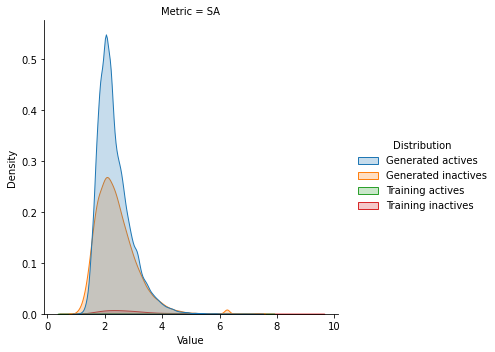

In [213]:
plot_distribution_basic(df_sa)

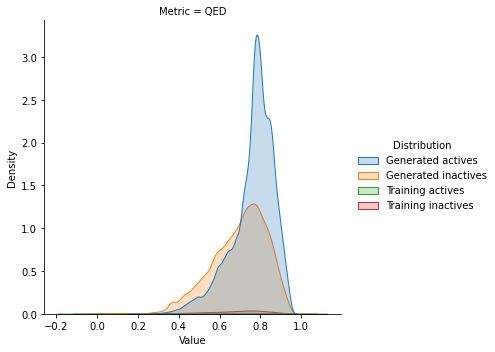

In [214]:
plot_distribution_basic(df_qed)

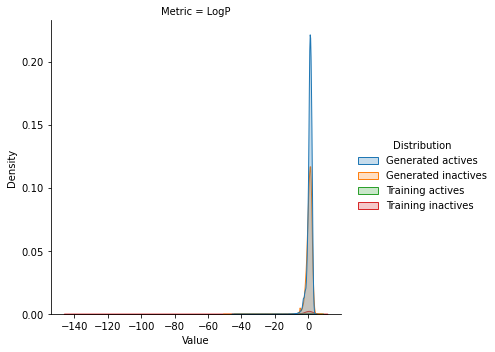

In [215]:
plot_distribution_basic(df_logp)

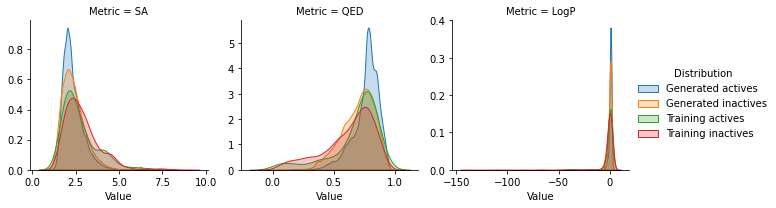

In [216]:
plot_distribution(df_metrics, save_path = "./aae_finetune_all_metrics.pdf", save = True)

## End of document